# Non Hermitian 3 site Ising model 

\begin{align*}
H_{\lambda, \kappa} = -\frac{1}{2} \sum_{j}^{L} \left( \lambda \sigma_j^x \sigma_{j+1}^x + \sigma_j^z + i \kappa \sigma_j^x \right),
\end{align*}

In [1]:
from qiskit import QuantumCircuit
import scipy.linalg as la
import numpy as np
from qiskit.primitives import Estimator
from qiskit.quantum_info import Operator, SparsePauliOp
from scipy.optimize import minimize
from qiskit.circuit.library import TwoLocal

lam = 1.0
kap = 0.2

H = SparsePauliOp(['XXI','IXX','ZII','IZI','IIZ','XII','IXI','IIX'],
                          [-0.5*lam,-0.5*lam,-0.5,-0.5,-0.5,-0.5j*kap,-0.5j*kap,-0.5j*kap])

# H = SparsePauliOp(['XXII','IXXI','ZIII','IZII','IIZI','XIII','IXIX','IIXI'],
#                           [-0.5*lam,-0.5*lam,-0.5,-0.5,-0.5,-0.5j*kap,-0.5j*kap,-0.5j*kap])
  
def VQA_1st_Step(theta, Er):
    
  ## theta contains Ei as first element
  Ei = theta[0]
  qc = ansatz.assign_parameters(theta[1:])
  H_minusE = H + SparsePauliOp([H.num_qubits*'I'],[-Er - 1j*Ei])
  operator = (H_minusE.conjugate() @ H_minusE).simplify()
  estimator = Estimator()
  result = estimator.run(qc, operator).result()
  return result.values[0]


def VQA_2nd_Step(theta):
    
  ## theta contains Er and Ei as 1st two elements
  Er = theta[0] ; Ei = theta[1] 
  qc = ansatz.assign_parameters(theta[2:])
  H_minusE = H + SparsePauliOp([H.num_qubits*'I'],[-Er - 1j*Ei])
  operator = (H_minusE.conjugate() @ H_minusE).simplify()
  estimator = Estimator()
  result = estimator.run(qc, operator).result()
  return result.values[0]


def get_energy(Er0, Ei0):
    
    x0 = np.random.random( len(ansatz.parameters) + 1 )

    x0[0] = Ei0

    result1 = minimize(lambda theta: VQA_1st_Step(theta,Er0), x0 = x0, method="BFGS") 

    x1 = np.concatenate(([Er0], result1.x))

    result2 = minimize(VQA_2nd_Step, x0 = x1, method="BFGS") 

    return [ result2.x[0], result2.x[1], result2.fun ]

ansatz = TwoLocal(H.num_qubits, ['ry', 'rz'], 'cz',reps=2)
get_energy(0.2,-1.5)

[np.float64(-0.0037219288285968793),
 np.float64(-0.04710786561208384),
 np.float64(1.797437999763625e-10)]

In [2]:
import random
Er0 = -2.0
E_max = 2.0
delE = 0.3

Eset0 = []

while (Er0 < E_max):

    Ei0 = random.randint(1,5)
    print(Ei0)
    
    result0 = get_energy(Er0, Ei0)
    
    Er = result0[0]
    Ei = result0[1]
    
    if result0[2] < 1.0e-09:
        Eset0.append(Er+1j*Ei)
        print(Er + 1j*Ei)
        print('LOSS: ',result0[2])

    result1 = get_energy(Er0, -1.0*Ei0)

    Er = result1[0]
    Ei = result1[1]

    if result1[2] < 1.0e-09:
        Eset0.append(Er+1j*Ei)
        print(Er + 1j*Ei)
        print('LOSS: ',result1[2])

    Er0 += delE


2
(-1.5144540947304033+0.040237102403211725j)
LOSS:  2.0544721479609507e-10
4
(-1.5144600557113987-0.04015557128531178j)
LOSS:  3.950839655431082e-11
(-1.514429947750755-0.0402019714783932j)
LOSS:  5.196210128843859e-11
2
5
2
(-0.4898979630238204-5.621641475670792e-07j)
LOSS:  1.3729188310815323e-11
(-0.4898980167630899+3.211618445893096e-06j)
LOSS:  3.734850442332105e-11
2
(-0.48990018804038493+1.451963038441179e-06j)
LOSS:  6.09753627377565e-10
(-0.4898970380511873+1.4706576018768468e-06j)
LOSS:  2.163863465164711e-11
3
(-0.003733104385861192-0.04712198030349993j)
LOSS:  7.206739285198216e-11
(-0.48989588238958653-3.094882076081451e-06j)
LOSS:  1.246335046853132e-10
5
(-0.0037314746579805965+0.047104875802366955j)
LOSS:  2.5381683639081644e-10
4
(0.48989671675071933-2.437037566887848e-06j)
LOSS:  4.3615351821411246e-10
(0.48989821994683014-3.9331232817923127e-07j)
LOSS:  9.26041304473809e-12
1
(0.4898979786165699-4.5383423631484246e-07j)
LOSS:  8.306617540547796e-12
(0.48989776925405

In [29]:
Eset = list(set([elem.round(3) for elem in Eset0]))
Erset = [elem.real for elem in Eset]
Eiset = [elem.imag for elem in Eset]

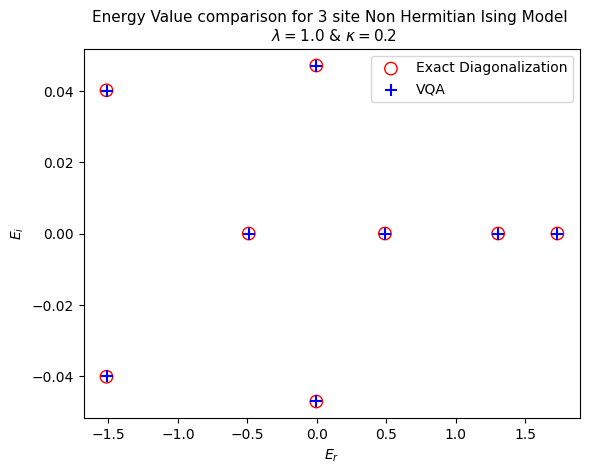

In [36]:
import matplotlib.pyplot as plt
main = la.eig(H)[0]
plt.xlabel('$E_r$')
plt.ylabel('$E_i$')
plt.scatter(main.real,main.imag,s= 80, facecolors = 'none', edgecolor = 'r',label = 'Exact Diagonalization')
plt.scatter(Erset,Eiset,s=70,marker = '+',label='VQA',color='b')
plt.legend()
plt.title("Energy Value comparison for 3 site Non Hermitian Ising Model \n "+ r"$\lambda = 1.0$ & $\kappa = 0.2 $", fontsize = 11)
plt.show()

In [31]:
Eset

[np.complex128(-0.49-0j),
 np.complex128(0.49-0j),
 np.complex128(1.305-0j),
 np.complex128(1.731+0j),
 np.complex128(-0.004+0.047j),
 np.complex128(-0.004-0.047j),
 np.complex128(-1.514-0.04j),
 np.complex128(-1.514+0.04j)]

In [32]:
main

array([-1.51444334+4.01665817e-02j, -1.51444334-4.01665817e-02j,
        1.73132063+9.84485690e-17j,  1.30502503+4.34752146e-17j,
       -0.00372949+4.71160714e-02j, -0.00372949-4.71160714e-02j,
       -0.48989795-9.99651222e-17j,  0.48989795-2.49349680e-17j])